<a href="https://colab.research.google.com/github/Nashra-Tazmeen/sentimental-model-with-TF-and-transformers/blob/main/Sentimental_Analysis_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!git clone https://github.com/Nashra-Tazmeen/sentimental-model-with-TF-and-transformers.git

fatal: destination path 'sentimental-model-with-TF-and-transformers' already exists and is not an empty directory.



**Preparing Data:**

We will start by reading the data into a Pandas Dataframe using th read_csv function. Because we're working with .tsv (tab seperate values) files we need to specify that we will be taking tab characters as the delimiters:

In [31]:
import pandas as pd

# Read the TSV file
df = pd.read_csv("/content/sentimental-model-with-TF-and-transformers/train.tsv", delimiter='\t')

df


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


The Phrase column contains all of our text data that we will be processing. We can also see that there are many copies through segments of the same answer (note that the SentenceId value for each of these copies is identical). We can reduce the amount of noise in our dataset by removing these duplicates.

Let's check the distribution of sentiment classes across our data.

<Axes: xlabel='Sentiment'>

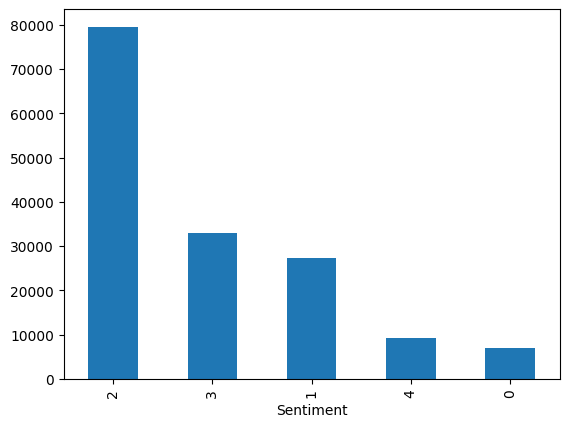

In [32]:
df['Sentiment'].value_counts().plot(kind='bar')

We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.

We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.

In [33]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

Now we can begin tokenizing with a BertTokenizer, like so:

In [34]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

Which returns us three numpy arrays - input_ids, token_type_ids, and attention_mask.

In [35]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [36]:
tokens['input_ids'][:10]

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]])

In [37]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [38]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [39]:
del tokens

Our input tensors are prepared, but we haven't touched our target data yet. So, let's move onto that.

Presently our target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe df. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions len(df) * number of label classes. Again, we will initialize a numpy zero array beforehand, but we won't populate it row by row - we will use some fancy indexing techniques instead.

In [40]:
# first extract sentiment column
arr = df['Sentiment'].values

In [41]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

We are able to use arr.max()+1 to define our second dimension here because we have the values [0, 1, 2, 3, 4] in our Sentiment column, there are five unique labels which means we need our labels array to have five columns (one for each) - arr.max() = 4, so we do 4 + 1 to get our required value of 5.

Now we use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array:

In [42]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [43]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

**Input pipeline**

In [44]:
import numpy as np


As we're using TensorFlow we can make use of the tf.data.Dataset object. First, we'll load in our Numpy binaries from file:

In [46]:
with open('movie-xids.npy','rb') as f:
  xids=np.load(f,allow_pickle=True)
with open('movie-xmask.npy','rb') as f:
  xmask=np.load(f,allow_pickle=True)
with open('movie-labels.npy','rb') as f:
  labels=np.load(f,allow_pickle=True)

In [47]:
xids.shape

(156060, 512)

In [48]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [50]:
import tensorflow as tf

We can take these three arrays and create a TF dataset object with them using from_tensor_slices like so:

In [51]:
dataset=tf.data.Dataset.from_tensor_slices((xids,xmask,labels))

In [52]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Each sample in our dataset is a tuple containing a single Xids, Xmask, and labels tensor. However, when feeding data into our model we need a two-item tuple in the format (<inputs>, <outputs>). Now, we have two tensors for our inputs - so, what we do is enter our <inputs> tensor as a dictionary:


{
    'input_ids': <input_id_tensor>,
    'attention_mask': <mask_tensor>
}

To rearrange the dataset format we can map a function that modifies the format like so:

In [54]:
def map_func(input_ids,masks,labels):
  # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
  return{'input_ids':input_ids,
         'attention_mask':masks},labels

In [55]:
# then we use the dataset map method to apply this transformation
dataset=dataset.map(map_func)

In [56]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Now we can see that our dataset sample format has been changed. Next, we need to shuffle our data, and batch it. We will take batch sizes of 16 and drop any samples that don't fit evenly into chunks of 16.

In [57]:
batch_size=16


In [58]:
dataset=dataset.shuffle(10000).batch(batch_size,drop_remainder=True)

In [59]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Now our dataset samples are organized into batches of 16. The final step is to split our data into training and validation sets. For this we use the take and skip methods, creating and 90-10 split.

In [64]:
split=0.9

In [65]:
size=xids.shape[0]
size

156060

In [67]:
int((xids.shape[0]/batch_size)*split)

8778

In [68]:
train_ds=dataset.take(size)
val_ds=dataset.skip(size)

Our two datasets are fully prepared for our model inputs. Now, we can save both to file using tf.data.experimental.save.

In [69]:
tf.data.experimental.save(train_ds,'train')
tf.data.experimental.save(val_ds,'val')


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [71]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [72]:
train_ds.element_spec==val_ds.element_spec

True

**Build and Train**
Now we're ready to begin building our sentiment classifier and begin training. We will be building out what is essentially a frame around Bert, that will allow us to perform language classification. First, we can initialize the Bert model, which we will load as a pretrained model from transformers.

In [73]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we need to define the frame around Bert, we need:




Two input layers (one for input IDs and one for attention mask).





A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

Max pooling layer to convert the 3D tensors output by Bert to 2D.

Final output activations using softmax for outputting categorical probabilities.

In [8]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Example input
input_text = "Example input text to obtain BERT embeddings."

# Tokenize input text
input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors='tf')

# Get BERT embeddings
outputs = bert_model(input_ids)
embeddings = outputs[1]  # Access final activations (already max-pooled)

# Continue with your downstream tasks using BERT embeddings


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

We can now define our model, specifying input and output layers. Finally, we can freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. Nonetheless, if you'd like to train Bert too, there is nothing wrong with doing so.

In [10]:

import tensorflow as tf
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example texts
texts = ["This is a test sentence.", "Another example sentence."]

# Tokenize the texts
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

# Extract input tensors
input_ids = tokenized_inputs['input_ids']
attention_mask = tokenized_inputs['attention_mask']

# Define the model
input_ids_input = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask_input = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
bert_outputs = bert_model(input_ids=input_ids_input, attention_mask=attention_mask_input)
# Add further layers and define the rest of the model architecture


In [13]:
# Define the optimizer using the legacy optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6)  # Example learning rate and decay

# Compile the model with the legacy optimizer
model.compile(optimizer=optimizer_legacy, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-15-dd164fcc4556>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1380, in step_function

Data type mismatch at component 0: expected double but got int64.
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_82956]